In [36]:
import sys
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install qiskit==1.4
!{sys.executable} -m pip install qiskit-optimization

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy

from functools import reduce
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
import random


from itertools import permutations
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.primitives import  Sampler
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import GroverOptimizer
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


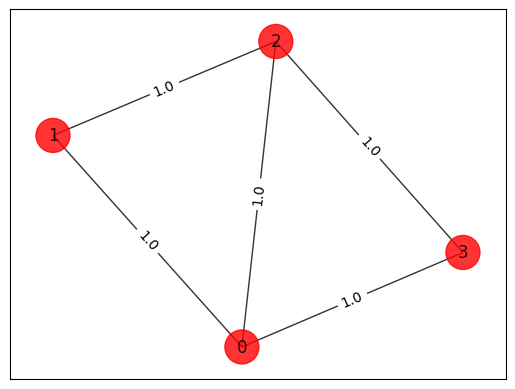

In [26]:
# Generamos un grafo

n = 4 # número de nodos
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)] #ejemplo para n=4
# elist =[(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0),(2,4, 1.0), (0,4,1.0)] #ejemplo para n=5

# cada tupla es de la forma (i,j,peso), siendo i y j los nodos que se van a unir por ese vértice
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

# Generamos la matriz de pesos
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


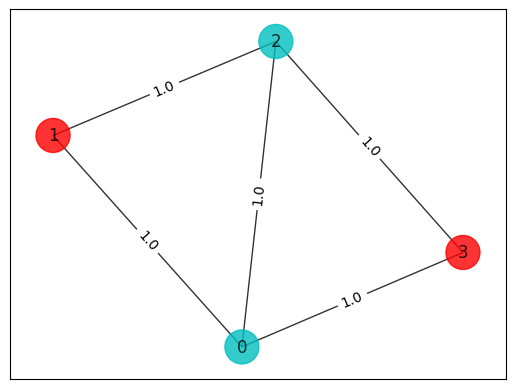

In [27]:
# Fuerza bruta
# Probamos todas las posibles combinaciones (2^n). En este ejemplo,  n=4 , tenemos un total de  16  combinaciones posibles. 

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
energy: -1.5
max-cut objective: -4.0
solution: [[1, 3], [0, 2]]
solution objective: 4.0


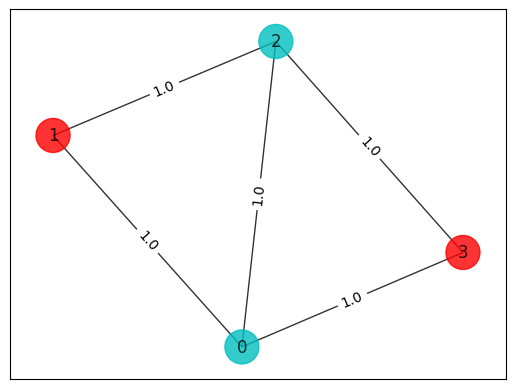

In [28]:
# Mapeado al problema de Ising
# Pasamos del grafo anterior al problema cuadrático
max_cut = Maxcut(w) #siendo w una matriz de pesos
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

# Pasamos del problema cuadrático a Hamiltoniano de Ising
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

# Como el problema fue trasladado a un problema de minimización, la solución se corresponde con la óptima.
# En resumen, de nuestro grafo pasamos a un problema QUBO y de ahí, a un hamiltoniano de Ising.
# Podemos comprobar que la solución obtenida por este método coincide con la anterior obtenida por fuerza bruta.

# Obtenemos el mínimo autovalor y su autovector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", max_cut.interpret(x))
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

/tmp/ipykernel_211344/3280831432.py:7: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=2, sampler=Sampler(), optimizer=COBYLA()))


objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS

solution: [[1, 3], [0, 2]]

time: 0.48662590980529785


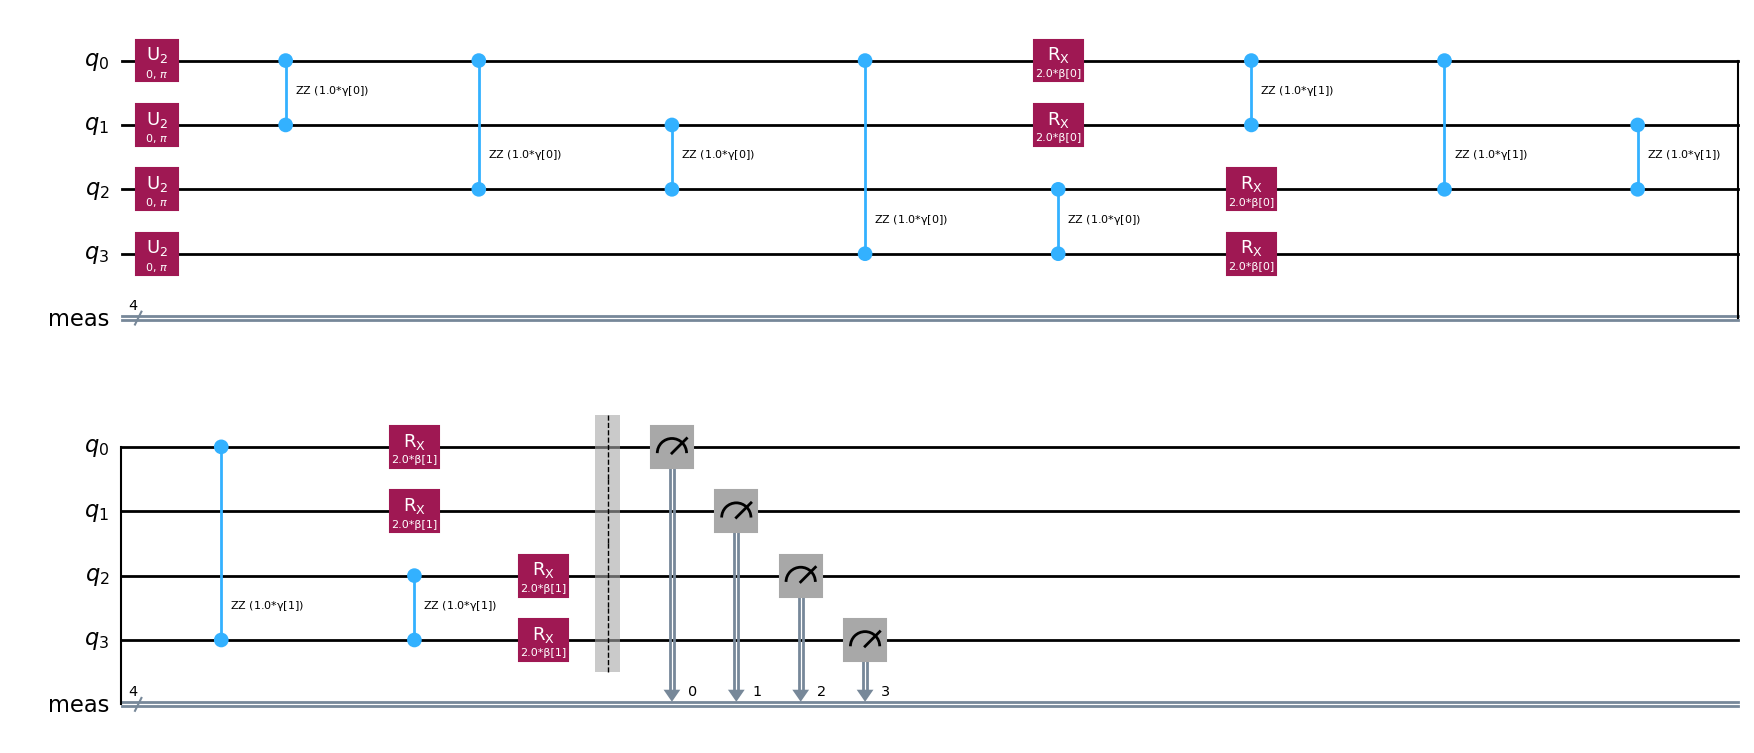

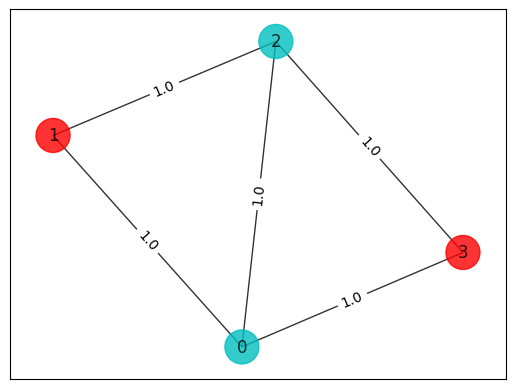

In [29]:
# Simulando un ordenador cuántico
# Fijamos las seeds para obtener todos los mismos resultados 'aleatorios'
algorithm_globals.random_seed = 123
seed = 10598

# QAOA
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=2, sampler=Sampler(), optimizer=COBYLA()))
result = meo.solve(qp)
print(result.prettyprint())
print("\nsolution:", max_cut.interpret(result))
print("\ntime:", result.min_eigen_solver_result.optimizer_time)
colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
meo.min_eigen_solver.ansatz.decompose(reps=1).draw('mpl')

/tmp/ipykernel_211344/733118169.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -1.4991477439555918
time: 2.5102572441101074
max-cut objective: -3.999147743955592
solution: [0 1 0 1]
solution objective: 4.0


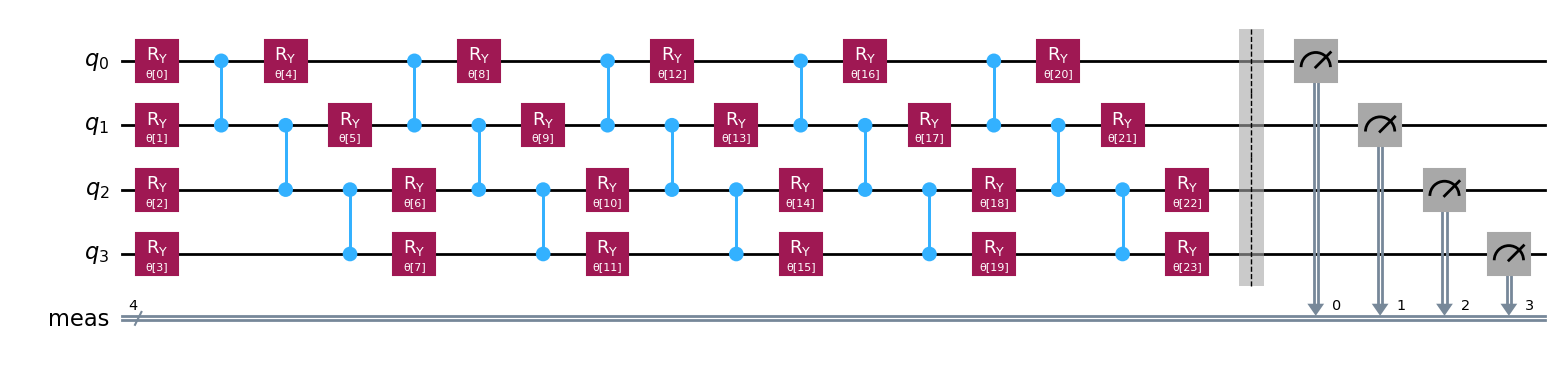

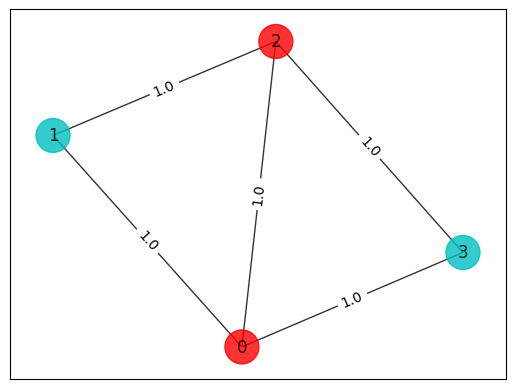

In [30]:
# VQE
# construct SamplingVQE
optimizer = SPSA(maxiter=300) #optimizador clásico y número de iteraciones
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

result.optimal_circuit.decompose().draw('mpl')

/tmp/ipykernel_211344/3881150724.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover_optimizer = GroverOptimizer(6, num_iterations=10, sampler=Sampler())


objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0
status: SUCCESS
Cut value: 4.0


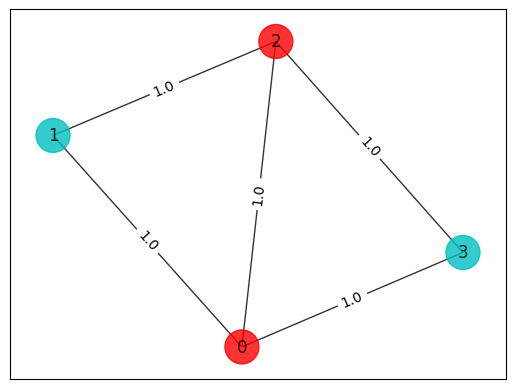

In [ ]:
# Grover Adaptative Search
grover_optimizer = GroverOptimizer(6, num_iterations=10, sampler=Sampler())
results = grover_optimizer.solve(qp)
print(results.prettyprint())
colors = ["r" if results.x[i] == 0 else "c" for i in range(len(results.x))]
draw_graph(G, colors, pos)
print("Cut value:", qp.objective.evaluate(results.x))

distance
 [[ 0. 39. 82. 82.]
 [39.  0. 83. 87.]
 [82. 83.  0.  8.]
 [82. 87.  8.  0.]]
distance
 [[ 0. 10. 50. 70.]
 [10.  0. 47. 54.]
 [50. 47.  0. 90.]
 [70. 54. 90.  0.]]


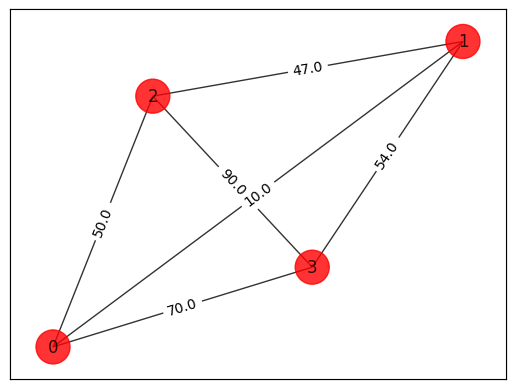

In [32]:
# Problema del viajante de comercio (Traveling Salesman Problem)
# Generamos un grafo aleatorio
# para n>3, el tiempo de cómputo se dispara
n = 4
num_qubits = n**2 #!
tsp = Tsp.create_random_instance(n) #seed para obtener los mismos resultados

adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

# también podemos definir el grafo a mano
n = 4  # número de nodos
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 10.0), (0, 2, 50.0), (0, 3, 70.0), (1, 2, 47.0), (1, 3, 54.0), (2,3, 90.0)]
G.add_weighted_edges_from(elist)
tsp=Tsp(G)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2, 3) Distance = 217.0
order = (0, 1, 3, 2) Distance = 204.0
Best order from brute force = (0, 1, 3, 2) with total distance = 204.0


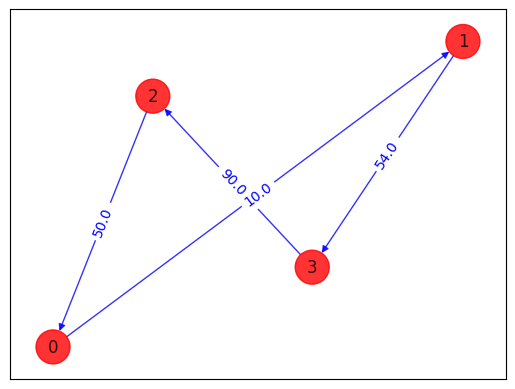

In [33]:
# Fuerza bruta
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

Problem name: TSP

Minimize
  10*x_0_0*x_1_1 + 10*x_0_0*x_1_3 + 50*x_0_0*x_2_1 + 50*x_0_0*x_2_3
  + 70*x_0_0*x_3_1 + 70*x_0_0*x_3_3 + 10*x_0_1*x_1_0 + 10*x_0_1*x_1_2
  + 50*x_0_1*x_2_0 + 50*x_0_1*x_2_2 + 70*x_0_1*x_3_0 + 70*x_0_1*x_3_2
  + 10*x_0_2*x_1_1 + 10*x_0_2*x_1_3 + 50*x_0_2*x_2_1 + 50*x_0_2*x_2_3
  + 70*x_0_2*x_3_1 + 70*x_0_2*x_3_3 + 10*x_0_3*x_1_0 + 10*x_0_3*x_1_2
  + 50*x_0_3*x_2_0 + 50*x_0_3*x_2_2 + 70*x_0_3*x_3_0 + 70*x_0_3*x_3_2
  + 47*x_1_0*x_2_1 + 47*x_1_0*x_2_3 + 54*x_1_0*x_3_1 + 54*x_1_0*x_3_3
  + 47*x_1_1*x_2_0 + 47*x_1_1*x_2_2 + 54*x_1_1*x_3_0 + 54*x_1_1*x_3_2
  + 47*x_1_2*x_2_1 + 47*x_1_2*x_2_3 + 54*x_1_2*x_3_1 + 54*x_1_2*x_3_3
  + 47*x_1_3*x_2_0 + 47*x_1_3*x_2_2 + 54*x_1_3*x_3_0 + 54*x_1_3*x_3_2
  + 90*x_2_0*x_3_1 + 90*x_2_0*x_3_3 + 90*x_2_1*x_3_0 + 90*x_2_1*x_3_2
  + 90*x_2_2*x_3_1 + 90*x_2_2*x_3_3 + 90*x_2_3*x_3_0 + 90*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

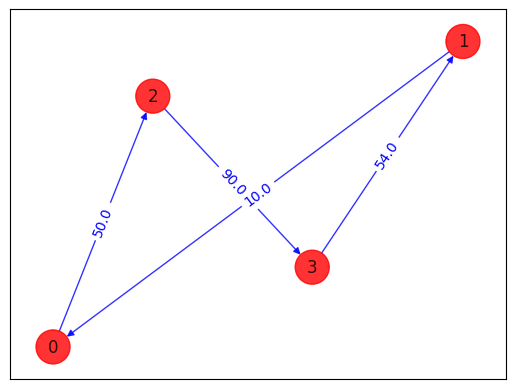

In [39]:
# Pasamos el problema a un problema de Ising
qp = tsp.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

# Creamos el Hamiltoniano completo, obtenemos su mínimo autovalor y su autovector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

/tmp/ipykernel_211344/2884375589.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=2, sampler=Sampler(), optimizer=COBYLA(maxiter=100))) #podemos probar a cambiar 'maxiter'


objective function value: 204.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS

solution: [3, 2, 0, 1]

time: 89.69014692306519


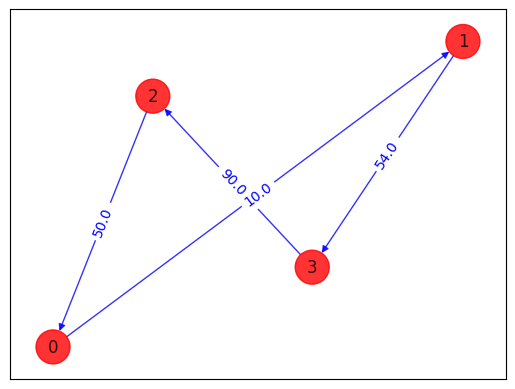

In [41]:
# QAOA
algorithm_globals.random_seed = 123
seed = 10598
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=2, sampler=Sampler(), optimizer=COBYLA(maxiter=100))) #podemos probar a cambiar 'maxiter'
result = meo.solve(qp)
print(result.prettyprint())
print("\nsolution:", tsp.interpret(result))
print("\ntime:", result.min_eigen_solver_result.optimizer_time)

draw_tsp_solution(tsp.graph,tsp.interpret(result),colors, pos)
meo.min_eigen_solver.ansatz.decompose(reps=1).draw('mpl', fold=50)

/tmp/ipykernel_211344/3086937106.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -35387.53863066206
time: 1193.8401062488556
feasible: True
solution: [3, 2, 1, 0]
solution objective: 217.0


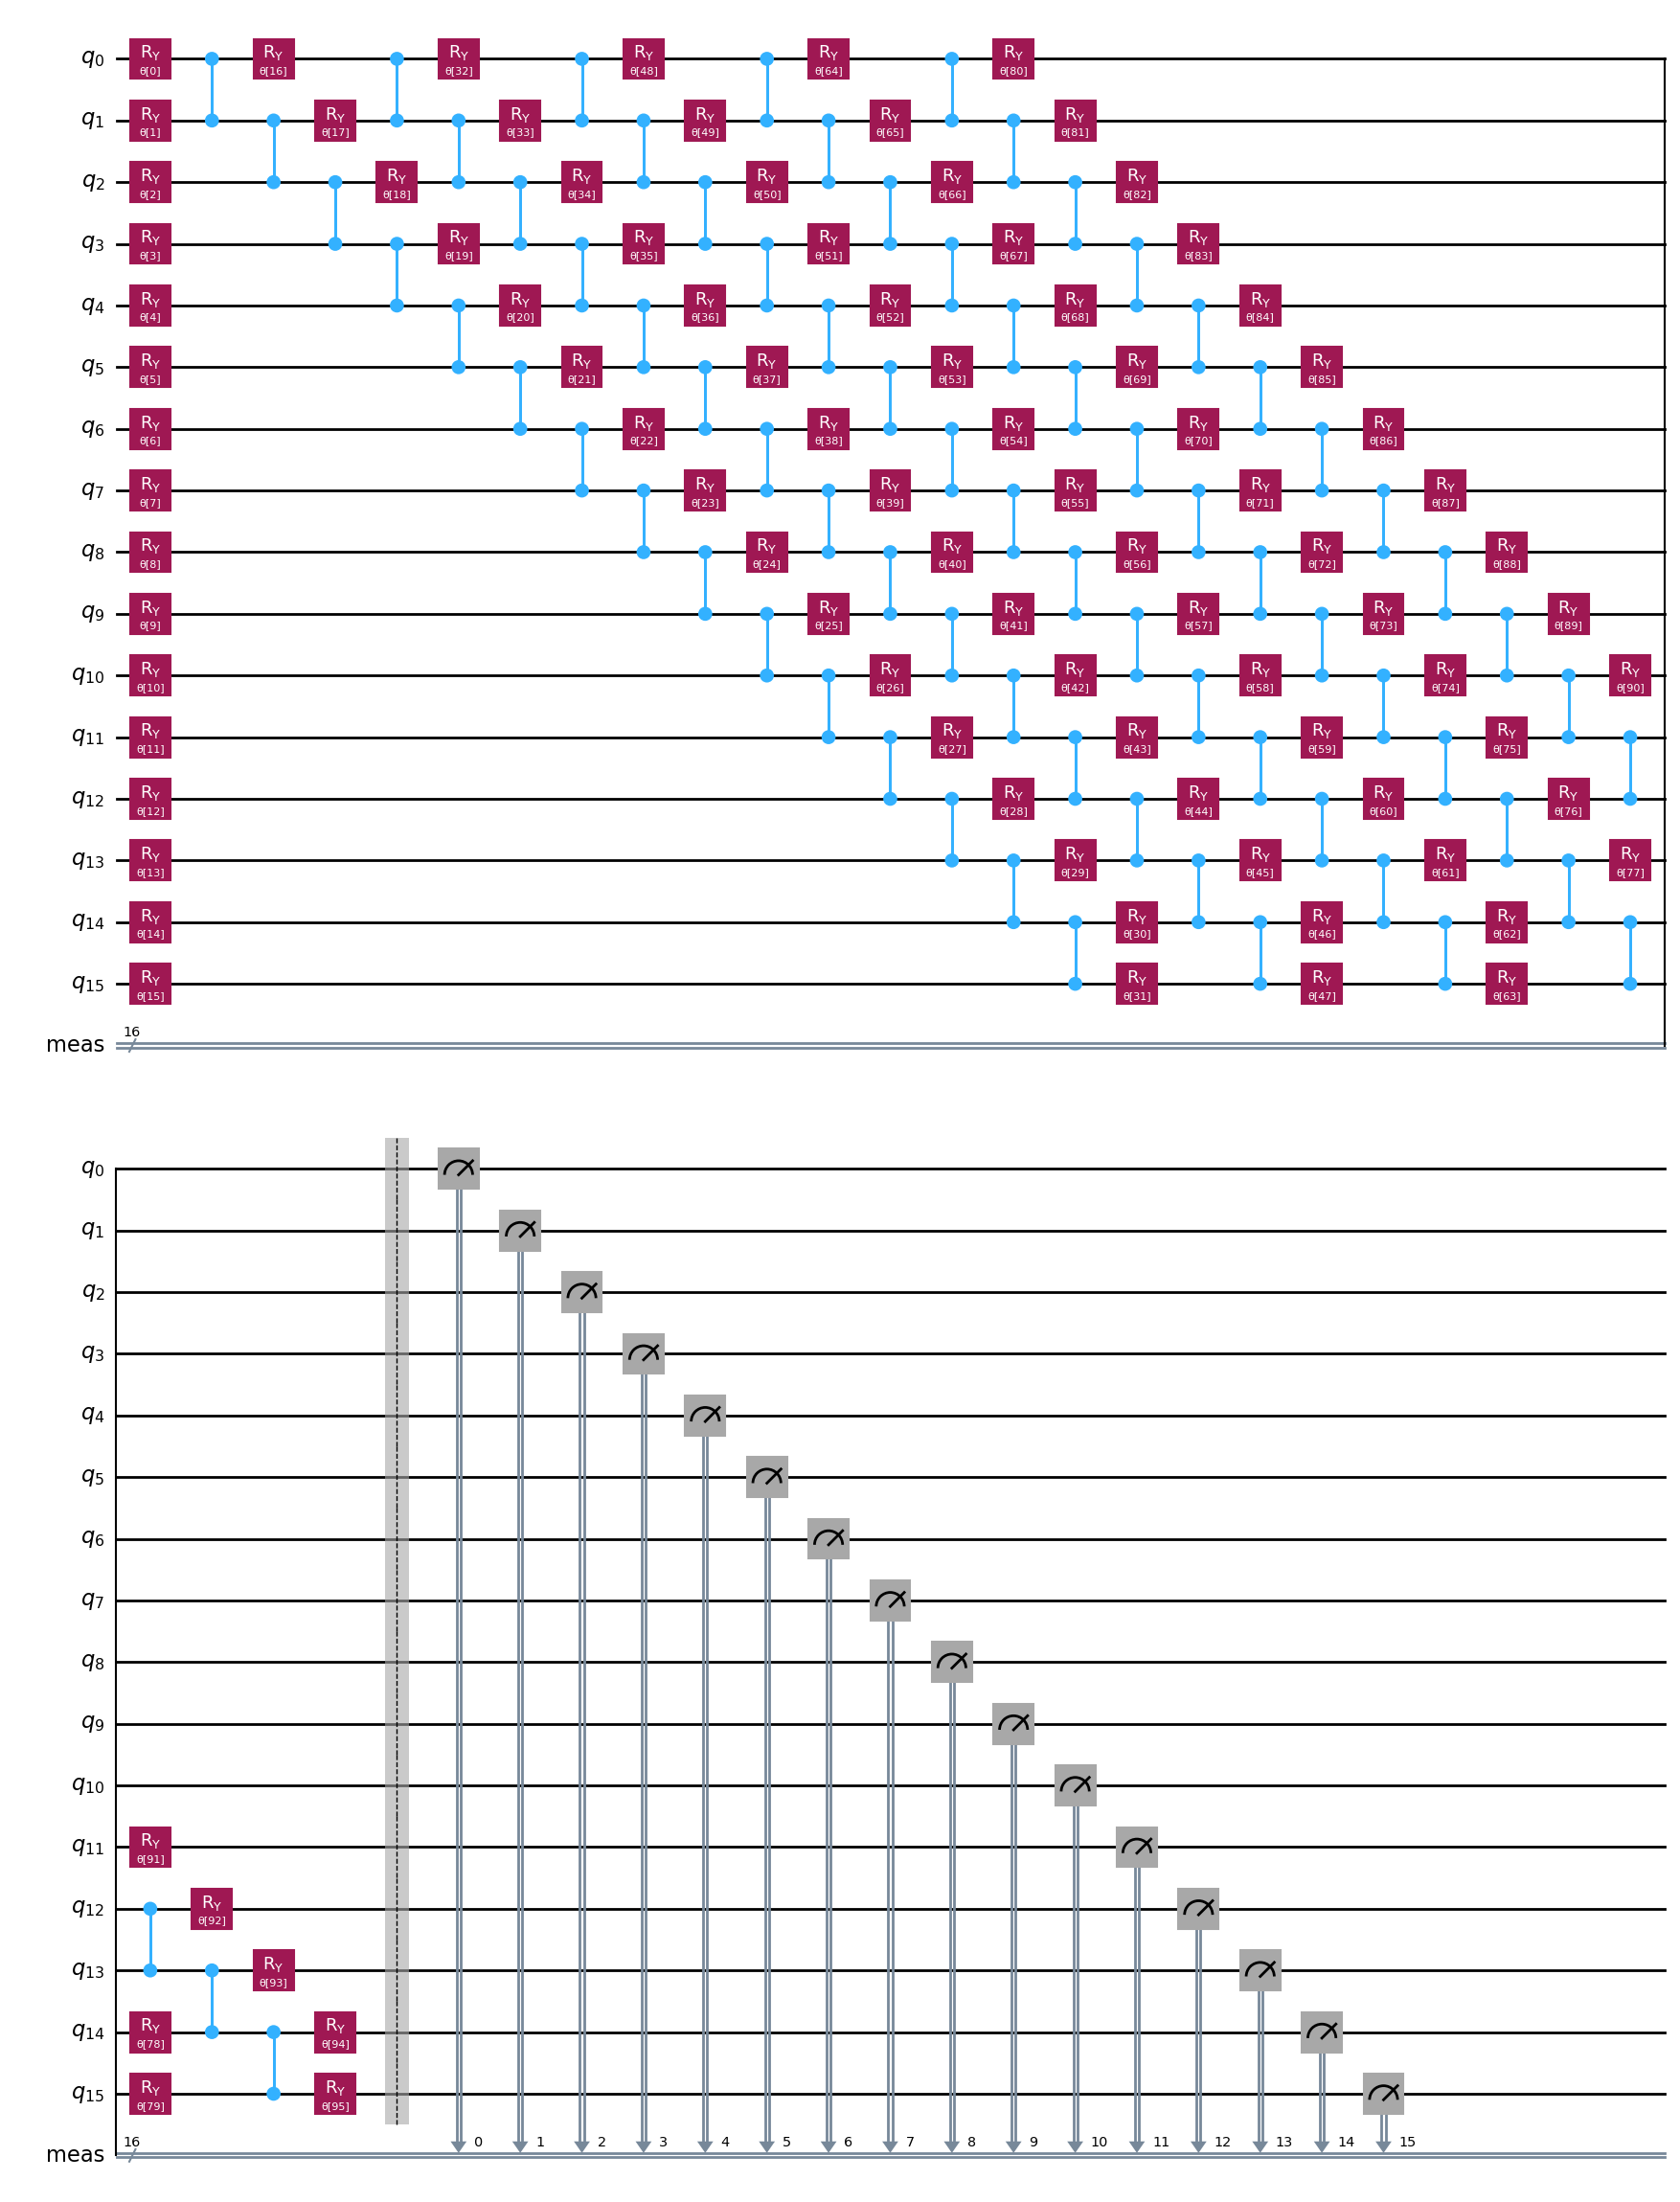

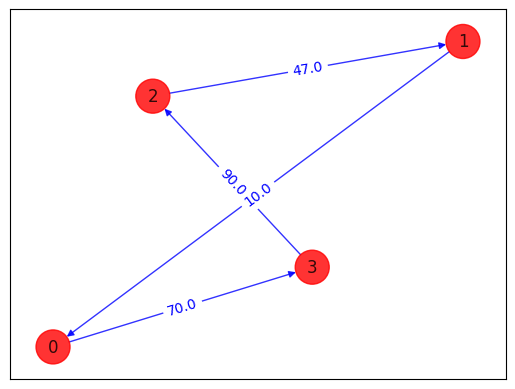

In [42]:
# VQE
optimizer = SPSA(maxiter=300) #podemos probar a cambiar este parámetro
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear") #podemos probar a cambiar el valor de reps
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
z[z.index([])] = (set(range(len(z))) - {x for x in z if isinstance(x, int)}).pop()
print("solution:", z)

print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)
result.optimal_circuit.decompose().draw('mpl')

In [44]:
# Grover Adaptative Search
grover_optimizer = GroverOptimizer(6, num_iterations=10, sampler=Sampler())
results = grover_optimizer.solve(qp)
print(results.prettyprint())

/tmp/ipykernel_211344/3619415042.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover_optimizer = GroverOptimizer(6, num_iterations=10, sampler=Sampler())


KeyboardInterrupt: 